# Domain Adaptation

In [1]:
from dataset import build_FIVES_dataloaders, build_hsi_dataloader, HSIDataset
from torch.utils.data import DataLoader

trainloader_source, validationloader_source, testloader_source = (
    build_FIVES_dataloaders(batch_size=16, width=224, height=224, cropped=True)
)

window=(500, 600)
trainloader_target = build_hsi_dataloader(
    batch_size=8,
    train_split=1,
    val_split=0,
    test_split=0,
    window=window,
    exclude_labeled_data=True,
    augmented=True,
)[0]

path = "./data/helicoid_with_labels"
testset = HSIDataset(path, with_gt=True, window=window)
testset.crop_dataset()
testloader_target = DataLoader(testset, batch_size=1, shuffle=False)
print(len(trainloader_target), len(testloader_target))

Number of samples in the training set: 640, validation set: 60
Number of samples in the test set: 200
8 5


## Evaluation of Model without Domain Adaptation on Target Testset

### Transfer Learning

In [3]:
from segmentation_util import evaluate_model, build_segmentation_model
import torch
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = build_segmentation_model('resnet50', 'Unet', device, in_channels=1)

evaluate_model(
    model, testloader_target, device, with_wandb=False
)

Precision: nan, Recall: 0.0239, F1 Score: 0.0410, Dice Score: 0.0410, Accuracy: 0.7850


(tensor(nan, device='cuda:3'),
 tensor(0.0239, device='cuda:3'),
 tensor(0.0410, device='cuda:3'),
 tensor(0.7850, device='cuda:3'),
 tensor(0.0410, device='cuda:3'))

### Ensemble Model

In [ ]:
from HSI_Net import SegmentationModelWithWindowing
from segmentation_util import build_segmentation_model, evaluate_model
from ensemble_model import EnsembleModelAverage
import segmentation_models_pytorch as smp
import torch

path = "./data/helicoid_with_labels"
testset = HSIDataset(path, with_gt=True)
testset.crop_dataset()
testloader_target = DataLoader(testset, batch_size=1, shuffle=False)

encoder = 'timm-regnetx_320'
architecture = 'Linknet'
device = ('cuda:3' if torch.cuda.is_available() else 'cpu')

segmenter_single_channel = build_segmentation_model(encoder, architecture, device)
segmenter_single_channel.load_state_dict(torch.load('./models/{architecture}-{encoder}-512x512-augmented-with-random-crops-single-channel-focal.pth'.format(architecture=architecture, encoder=encoder)))
segmenter_single_channel.eval()

window1 = (400, 500)
window2 = (500, 600)
window3 = (600, 700)
window4 = (700, 800)
window5 = (800, 900)
window6 = (900, 1000)
window_full = (400, 1100)


model_windowing_400to500 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window1))
model_with_windowing_500to600 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window2))
model_windowing_600to700 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window3))
model_windowing_700to800 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window4))
model_windowing_800to900 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window5))
model_windowing_900to1000 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window6))
model_window_full = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window_full))

model = EnsembleModelAverage([model_windowing_400to500, model_with_windowing_500to600, model_windowing_600to700, model_windowing_700to800, model_windowing_900to1000, model_window_full])
evaluate_model(model, testloader_target, device, with_wandb=False)

Precision: 0.5368, Recall: 0.2351, F1 Score: 0.3072, Dice Score: 0.3072, Accuracy: 0.8104


(tensor(0.5368, device='cuda:3'),
 tensor(0.2351, device='cuda:3'),
 tensor(0.3072, device='cuda:3'),
 tensor(0.8104, device='cuda:3'),
 tensor(0.3072, device='cuda:3'))

## Domain Adaptation Approaches:
### GRL domain adaptation

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Loading pretrained model from ./models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descript

Epoch 1, Batch 10/40, Total Loss: 4.3466, Segmentation Loss: 0.7781, Domain Loss Source: 0.3439, Domain Loss Target: 1.2840
Epoch 1, Batch 20/40, Total Loss: 2.3114, Segmentation Loss: 0.8487, Domain Loss Source: 0.4021, Domain Loss Target: 0.9387
Epoch 1, Batch 30/40, Total Loss: 2.0392, Segmentation Loss: 0.6678, Domain Loss Source: 0.9815, Domain Loss Target: 0.3280
Epoch 1, Batch 40/40, Total Loss: 1.9166, Segmentation Loss: 0.6069, Domain Loss Source: 0.5327, Domain Loss Target: 0.6204
Epoch 1, Train Loss: 2.6535
Evaluating model performance on source data
Precision: 0.4241, Recall: 0.2483, F1 Score: 0.3076, Dice Score: 0.3076, Accuracy: 0.9671
Evaluating model performance on target data
Precision: 0.4526, Recall: 0.5617, F1 Score: 0.4858, Dice Score: 0.4858, Accuracy: 0.7719
Epoch 1, Validation Loss Source: 0.7438, Validation Loss Target: 0.5408
Epoch 2, Batch 10/40, Total Loss: 1.9330, Segmentation Loss: 0.6071, Domain Loss Source: 0.7142, Domain Loss Target: 0.4595
Epoch 2, Bat

dice_score/source,▁▄▄▅▇▅▆▆▇█
dice_score/target,▆█▄▅▇▃▇▄▁▅
epoch,▁▂▃▃▄▅▆▆▇█
precision/source,▁▆██▇██▇█▆
precision/target,▁█▃▄▅▁▅▃▃▂
test/accuracy,▁
test/dice_score,▁
test/f1_score,▁
test/precision,▁
test/recall,▁
train/domain_loss,▆▁▁▂▁▄▂█▂▃


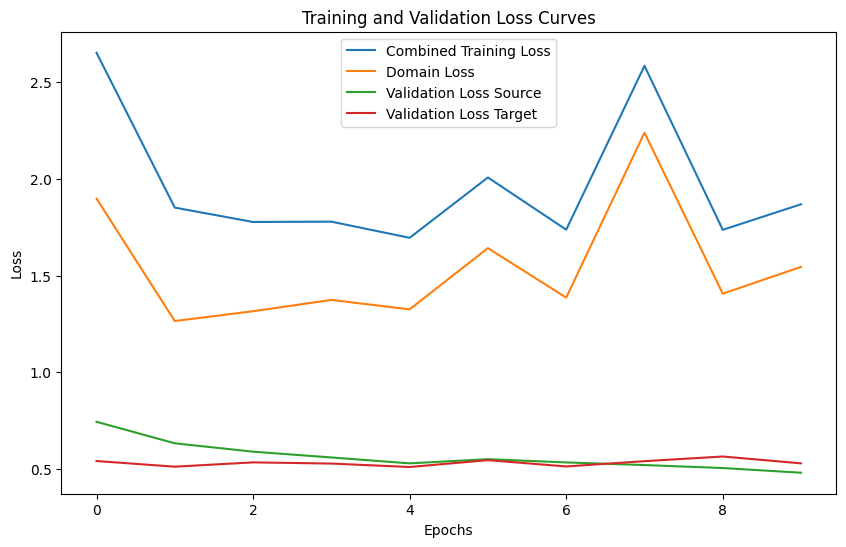

In [2]:
import matplotlib.pyplot as plt
import torch
from domain_adaptation_training import model_pipeline

encoder = "timm-regnetx_320"
architecture = "Linknet"
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
lambda_param = 0.5
learning_rate = 0.001
loss = "Dice"
epochs = 10
in_channels = 1
hidden_dim = 256

config = {
    "model": "GRL-{architecture}-{encoder}-window_{window[0]}-{window[1]}-pretrained-augmented_target".format(
        architecture=architecture, encoder=encoder, window=window
    ),
    "encoder": encoder,
    "architecture": architecture,
    "learning_rate": learning_rate,
    "optimizer": "Adam",
    "lambda_param": lambda_param,
    "batch_size_source": trainloader_source.batch_size,
    "batch_size_target": trainloader_target.batch_size,
    "hidden_dim": hidden_dim,
    "epochs": epochs,
    "loss": loss,
    "in_channels": in_channels,
    "pretrained": './models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth'
}

model, train_losses, domain_losses, val_losses_source, val_losses_target = model_pipeline(
    trainloader_source,
    validationloader_source,
    testloader_source,
    trainloader_target,
    testloader_target,
    config,
    project="domain-adaptation",
    device=device,
    batch_print=10,
    evaluate=True,
    with_overlays=True,
)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Combined Training Loss")
plt.plot(domain_losses, label="Domain Loss")
plt.plot(val_losses_source, label="Validation Loss Source")
plt.plot(val_losses_target, label="Validation Loss Target")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

### FADA:

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Loading pretrained model from ./models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Batch 10/40, Total Loss: 0.9472, Segmentation Loss: 0.3088, Domain Loss Source: 0.2891, Domain Loss Target: 0.2266, Adversarial Loss Target: 0.0009
Epoch 1, Batch 20/40, Total Loss: 0.8102, Segmentation Loss: 0.2770, Domain Loss Source: 0.2884, Domain Loss Target: 0.2098, Adversarial Loss Target: 0.0013
Epoch 1, Batch 30/40, Total Loss: 0.7358, Segmentation Loss: 0.2326, Domain Loss Source: 0.1636, Domain Loss Target: 0.3830, Adversarial Loss Target: 0.0016
Epoch 1, Batch 40/40, Total Loss: 0.7374, Segmentation Loss: 0.1973, Domain Loss Source: 0.1848, Domain Loss Target: 0.2148, Adversarial Loss Target: 0.0021
Epoch 1, Train Loss: 4.4866


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Evaluating model performance on source data
Precision: 0.7405, Recall: 0.0433, F1 Score: 0.0809, Dice Score: 0.0809, Accuracy: 0.9703
Evaluating model performance on target data
Precision: 0.6147, Recall: 0.1450, F1 Score: 0.2209, Dice Score: 0.2209, Accuracy: 0.8084
Epoch 1, Validation Loss Source: 0.1536, Validation Loss Target: 0.5338
Epoch 2, Batch 10/40, Total Loss: 0.6690, Segmentation Loss: 0.1886, Domain Loss Source: 0.2084, Domain Loss Target: 0.1735, Adversarial Loss Target: 0.0018
Epoch 2, Batch 20/40, Total Loss: 0.6390, Segmentation Loss: 0.1649, Domain Loss Source: 0.2804, Domain Loss Target: 0.1129, Adversarial Loss Target: 0.0016
Epoch 2, Batch 30/40, Total Loss: 0.5954, Segmentation Loss: 0.1606, Domain Loss Source: 0.1485, Domain Loss Target: 0.3003, Adversarial Loss Target: 0.0009
Epoch 2, Batch 40/40, Total Loss: 0.6678, Segmentation Loss: 0.1391, Domain Loss Source: 0.1411, Domain Loss Target: 0.3800, Adversarial Loss Target: 0.0011
Epoch 2, Train Loss: 3.5393
Eval

dice_score/source,▁▂▃▄▅▆▆▇▇▇▇▇████████
dice_score/target,▂▁▅▆▇▇▇▇▇▇█▇▇█▇▇█▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
precision/source,▄██▇▆▆▆▅▅▅▅▅▄▃▄▃▂▂▁▂
precision/target,▅▆█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
test/accuracy,▁
test/dice_score,▁
test/f1_score,▁
test/precision,▁
test/recall,▁
train/domain_loss,█▁▁▄▂▃▂▂▂▄▂▆▄▄▄▆▄▄▆▄


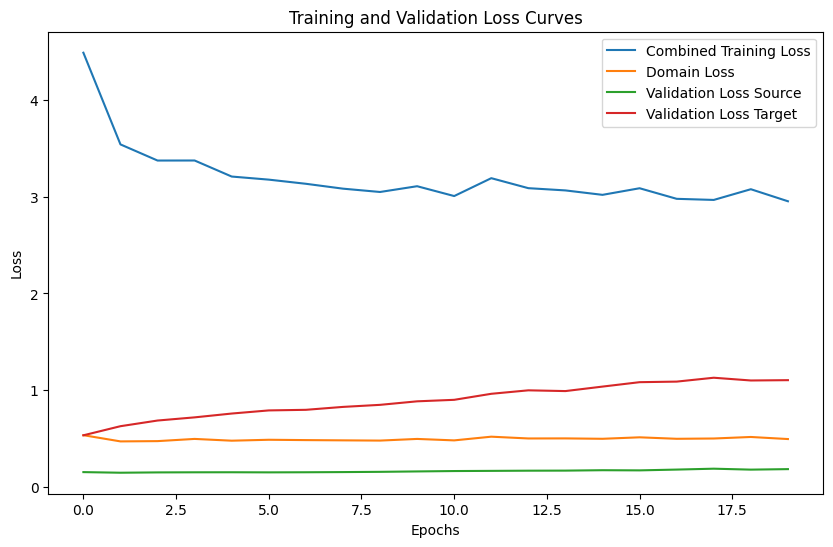

In [2]:
import matplotlib.pyplot as plt
from FADA.train_FADA import model_pipeline
import torch

encoder = "timm-regnetx_320"
architecture = "Linknet"
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
epochs = 20
loss = "BCE"
in_channels = 1
ndf=512
learning_rate_fea = 0.001
learning_rate_cls = 0.001
learning_rate_dis = 0.0001

config = {
    "model": "FADA-{architecture}-{encoder}-cropped-window_{window[0]}-{window[1]}_pretrained-augmented_target".format(
        architecture=architecture, encoder=encoder, window=window
    ),
    "encoder": encoder,
    "architecture": architecture,
    "in_channels": in_channels,
    "optimizer": "Adam",
    "batch_size_source": trainloader_source.batch_size,
    "batch_size_target": trainloader_target.batch_size,
    "learning_rate_fea": learning_rate_fea,
    "learning_rate_cls": learning_rate_cls,
    "learning_rate_dis": learning_rate_dis,
    "ndf": ndf,
    "epochs": epochs,
    "seg_loss": loss,
    "pretrained": "./models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth",
}


model, train_losses, domain_losses, val_losses_source, val_losses_target = model_pipeline(
    trainloader_source,
    validationloader_source,
    testloader_source,
    trainloader_target,
    testloader_target,
    config,
    project="domain-adaptation",
    device=device,
    batch_print=10,
    evaluate=True,
    with_overlays=True,
)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Combined Training Loss")
plt.plot(domain_losses, label="Domain Loss")
plt.plot(val_losses_source, label="Validation Loss Source")
plt.plot(val_losses_target, label="Validation Loss Target")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()